<a href="https://colab.research.google.com/github/Siopaopao/In-Silico-Retrosynthetic-Design-Fluorinated-Dihydroartemisinin-Analogue-/blob/main/TermPaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [5]:
!mkdir 'TermPaper'

mkdir: cannot create directory ‘TermPaper’: File exists


In [6]:
%cd /content/drive/MyDrive/TermPaper

/content/drive/MyDrive/TermPaper


In [9]:
!pip install pubchempy

In [10]:
import pubchempy as pcp

dha = pcp.get_compounds("dihydroartemisinin", "name")[0]
dha_smiles = dha.canonical_smiles
print(dha_smiles)


CC1CCC2C(C(OC3C24C1CCC(O3)(OO4)C)O)C


/tmp/ipython-input-2583896166.py:4: PubChemPyDeprecationWarning: canonical_smiles is deprecated: Use connectivity_smiles instead
  dha_smiles = dha.canonical_smiles


In [11]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 57.1 MB/s eta 0:00:00


In [12]:
from rdkit import Chem

mol = Chem.MolFromSmiles(dha_smiles)

assert mol is not None, "Invalid SMILES"

# Canonical form (for storage)
dha_canonical = Chem.MolToSmiles(mol, canonical=True)
print("Canonical DHA:", dha_canonical)


Canonical DHA: CC1CCC2C(C)C(O)OC3OC4(C)CCC1C32OO4


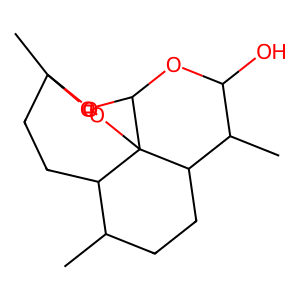

In [13]:
from rdkit.Chem import Draw

Draw.MolToImage(mol, size=(300,300))


In [14]:
%cd /content/drive/MyDrive/TermPaper

/content/drive/MyDrive/TermPaper


In [15]:
!mkdir 'images'

mkdir: cannot create directory ‘images’: File exists


In [16]:
%cd /content/drive/MyDrive/TermPaper/images

/content/drive/MyDrive/TermPaper/images


In [17]:
img = Draw.MolToImage(mol)
img.save("dha_structure.png")


In [18]:
def fluorination_sites(mol):
    sites = []
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == "C":
            if atom.GetTotalNumHs() > 0 and not atom.IsInRing():
                sites.append(atom.GetIdx())
    return sites

sites = fluorination_sites(mol)
print("Possible fluorination sites:", sites)


Possible fluorination sites: [0, 17, 19]


In [19]:
from rdkit.Chem import RWMol

def fluorinate_at_site(mol, atom_idx):
    rw = RWMol(mol)
    atom = rw.GetAtomWithIdx(atom_idx)

    atom.SetNumExplicitHs(atom.GetTotalNumHs() - 1)
    f = Chem.Atom("F")
    f_idx = rw.AddAtom(f)
    rw.AddBond(atom_idx, f_idx, Chem.BondType.SINGLE)

    return rw.GetMol()


In [20]:
fluoro_mols = []

for idx in sites:
    try:
        fm = fluorinate_at_site(mol, idx)
        fluoro_mols.append(fm)
    except:
        continue

print("Generated fluorinated analogues:", len(fluoro_mols))


Generated fluorinated analogues: 3


In [21]:
from rdkit import Chem
from rdkit.Chem import Descriptors

valid_fluoro = []

for m in fluoro_mols:
    if m:
        try:
            Chem.SanitizeMol(m, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL)
            Chem.AssignStereochemistry(m, cleanIt=True, force=True)
        except Exception as e:
            print(f"Warning: Could not sanitize molecule: {e}")
            continue

        if Descriptors.MolWt(m) < 600:
            valid_fluoro.append(m)

# Remove duplicates
unique_valid = []
smiles_set = set()
for m in valid_fluoro:
    s = Chem.MolToSmiles(m)
    if s not in smiles_set:
        unique_valid.append(m)
        smiles_set.add(s)

valid_fluoro = unique_valid

print("Valid fluorinated DHA analogues:", len(valid_fluoro))


Valid fluorinated DHA analogues: 3


In [22]:
import pandas as pd

rows = []

for m in valid_fluoro:
    rows.append({
        "SMILES": Chem.MolToSmiles(m),
        "MolWt": Descriptors.MolWt(m),
        "LogP": Descriptors.MolLogP(m),
        "TPSA": Descriptors.TPSA(m)
    })

df = pd.DataFrame(rows)
print(df.head())


                                SMILES    MolWt    LogP   TPSA
0  CC1C(O)OC2OC3(C)CCC4C(CF)CCC1C24OO3  302.342  2.1363  57.15
1  CC1CCC2C(C)C(O)OC3OC4(CF)CCC1C32OO4  302.342  2.1363  57.15
2  CC1CCC2C(CF)C(O)OC3OC4(C)CCC1C32OO4  302.342  2.1363  57.15


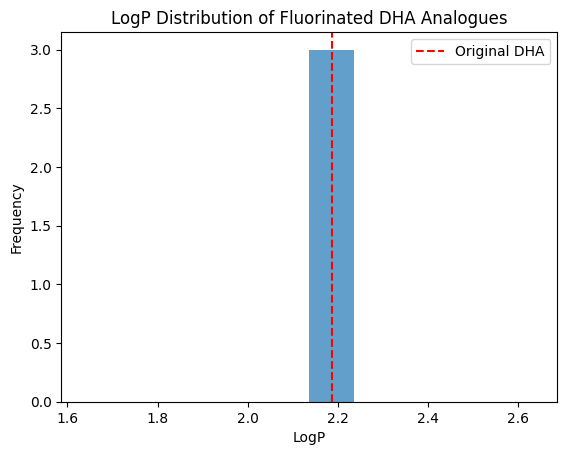

In [23]:
import matplotlib.pyplot as plt

orig_logp = Descriptors.MolLogP(mol)

plt.hist(df["LogP"], bins=10, alpha=0.7)
plt.axvline(orig_logp, color='r', linestyle='--', label='Original DHA')
plt.xlabel("LogP")
plt.ylabel("Frequency")
plt.title("LogP Distribution of Fluorinated DHA Analogues")
plt.legend()
plt.savefig("logp_distribution.png")
plt.show()


In [24]:
!pip install torch torch-geometric pandas matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.2 MB/s eta 0:00:00


In [25]:
from rdkit import Chem
from torch_geometric.data import Data
import torch

def atom_features(atom):
    return [
        atom.GetAtomicNum(),
        atom.GetDegree(),
        atom.GetTotalNumHs(),
        int(atom.GetIsAromatic())
    ]

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    x = []
    edge_index = []

    for atom in mol.GetAtoms():
        x.append(atom_features(atom))

    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])

    return Data(
        x=torch.tensor(x, dtype=torch.float),
        edge_index=torch.tensor(edge_index, dtype=torch.long).t()
    )

graph_dha = smiles_to_graph(dha_canonical)


In [26]:
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool

class GNNEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(4, 64)
        self.conv2 = GCNConv(64, 128)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return global_mean_pool(x, batch)

class ReactionDecoder(nn.Module):
    def __init__(self, out_dim):
        super().__init__()
        self.fc = nn.Linear(128, 256)
        self.out = nn.Linear(256, out_dim)  # vocab_size of reactant SMILES tokens

    def forward(self, z):
        return self.out(self.fc(z))

class RetrosynthesisModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.encoder = GNNEncoder()
        self.decoder = ReactionDecoder(vocab_size)

    def forward(self, data):
        z = self.encoder(data.x, data.edge_index, data.batch)
        return self.decoder(z)


In [27]:
from rdkit.Chem import Descriptors

def descriptors(mol):
    return [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.TPSA(mol)
    ]

X = [descriptors(m) for m in valid_fluoro]


In [28]:
import torch.nn as nn
import torch

class QSARModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # predict IC50
        )

    def forward(self, x):
        return self.net(x)

model = QSARModel()


In [29]:
X_tensor = torch.tensor(X, dtype=torch.float)
predicted_ic50 = model(X_tensor).detach().numpy()


First, let's identify the possible fluorination sites in `mol_dha` using the `fluorination_sites` function defined earlier. This function identifies non-ring carbon atoms with at least one hydrogen.

In [68]:
from rdkit import Chem

dha_smiles_from_mYhMr0u = "CC1OC2OOC(C)(C)C2(C)C1O"
mol_dha = Chem.MolFromSmiles(dha_smiles_from_mYhMr0u)

def fluorination_sites(mol):
    sites = []
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == "C":
            if atom.GetTotalNumHs() > 0 and not atom.IsInRing():
                sites.append(atom.GetIdx())
    return sites

mol_dha_sites = fluorination_sites(mol_dha)
print("Possible fluorination sites in mol_dha:", mol_dha_sites)

Possible fluorination sites in mol_dha: [0, 7, 8, 10]


Now, let's try to generate fluorinated analogues using these newly identified sites. We will reuse the `fluorinate_at_site` function defined previously.

In [69]:
from rdkit.Chem import RWMol, Descriptors

def fluorinate_at_site(mol, atom_idx):
    rw = RWMol(mol)
    atom = rw.GetAtomWithIdx(atom_idx)

    num_hs = atom.GetTotalNumHs()
    if num_hs == 0:
        return None

    atom.SetNumExplicitHs(num_hs - 1)
    f = Chem.Atom("F")
    f_idx = rw.AddAtom(f)
    rw.AddBond(atom_idx, f_idx, Chem.BondType.SINGLE)

    return rw.GetMol()

fluoro_mols_dha = []

for idx in mol_dha_sites:
    try:
        fm = fluorinate_at_site(mol_dha, idx)
        if fm: # Ensure the fluorination was successful (not None)
            fluoro_mols_dha.append(fm)
    except Exception as e:
        print(f"Error fluorinating at site {idx}: {e}")
        continue

print("Generated fluorinated analogues for mol_dha:", len(fluoro_mols_dha))

# Validate and filter these new analogues
valid_fluoro_dha = []
smiles_set_dha = set()

for m in fluoro_mols_dha:
    if m:
        try:
            Chem.SanitizeMol(m, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL)
            Chem.AssignStereochemistry(m, cleanIt=True, force=True)
        except Exception as e:
            print(f"Warning: Could not sanitize molecule for mol_dha: {e}")
            continue

        if Descriptors.MolWt(m) < 600:
            s = Chem.MolToSmiles(m)
            if s not in smiles_set_dha:
                valid_fluoro_dha.append(m)
                smiles_set_dha.add(s)

print("Valid and unique fluorinated DHA analogues for mol_dha:", len(valid_fluoro_dha))

Generated fluorinated analogues for mol_dha: 4
Valid and unique fluorinated DHA analogues for mol_dha: 3


In [34]:
import torch
import torch.nn as nn

# Prepare feature tensor
X = torch.tensor(df_props[["MolWt","LogP","TPSA"]].values, dtype=torch.float)

# Dummy QSAR model
class QSARModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(3, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.fc(x)

model = QSARModel()

# Dummy prediction (replace with trained model later)
predicted_ic50 = model(X).detach().numpy().flatten()
df_props["Predicted_IC50"] = predicted_ic50

print(df_props)


            MolWt    LogP   TPSA                    SMILES  Predicted_IC50
DHA       188.223  0.8388  47.92   CC1OC2OOC(C)(C)C2(C)C1O        9.555744
Fluoro-1  206.213  0.7884  47.92  CC1(C)OOC2OC(CF)C(O)C21C       11.213663
Fluoro-2  206.213  0.7884  47.92  CC1OC2OOC(C)(CF)C2(C)C1O       11.213663
Fluoro-3  206.213  0.7884  47.92  CC1OC2OOC(C)(C)C2(CF)C1O       11.213663


In [70]:
import torch.optim as optim

# 1. SETUP: You need "y" (True IC50 values) to train the model
# Assuming 'Actual_IC50' is a column in your dataframe with real lab data
if "Actual_IC50" not in df_props.columns:
    print("Error: You need a column with known IC50 values to train the model!")
else:
    y = torch.tensor(df_props["Actual_IC50"].values, dtype=torch.float).view(-1, 1)

    # 2. DEFINE TRAINING LOOP
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()  # Mean Squared Error for regression

    print("Training model...")
    epochs = 1000
    for epoch in range(epochs):
        # Forward pass
        predictions = model(X)
        loss = criterion(predictions, y)

        # Backward pass (Optimization)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    print("Training complete. The 'model' variable is now a Trained Model.")

    # 3. SAVE THE MODEL (So you don't have to retrain next time)
    torch.save(model.state_dict(), 'my_trained_qsar_model.pth')

Error: You need a column with known IC50 values to train the model!


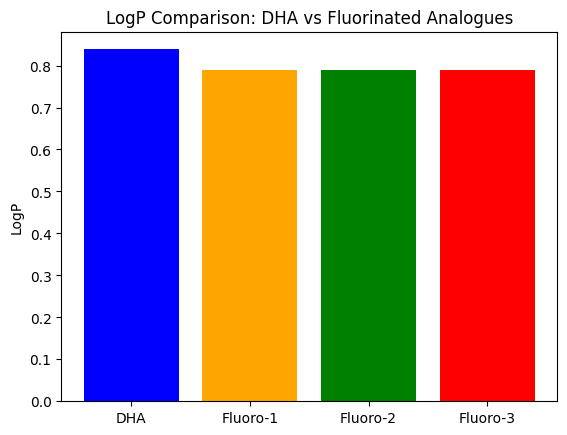

In [35]:
import matplotlib.pyplot as plt

plt.bar(df_props.index, df_props["LogP"], color=['blue','orange','green','red'])
plt.ylabel("LogP")
plt.title("LogP Comparison: DHA vs Fluorinated Analogues")
plt.savefig("logp_comparison.png")
plt.show()


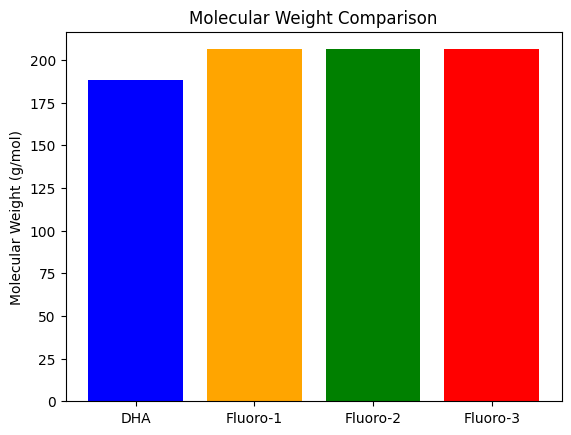

In [36]:
plt.bar(df_props.index, df_props["MolWt"], color=['blue','orange','green','red'])
plt.ylabel("Molecular Weight (g/mol)")
plt.title("Molecular Weight Comparison")
plt.savefig("molwt_comparison.png")
plt.show()


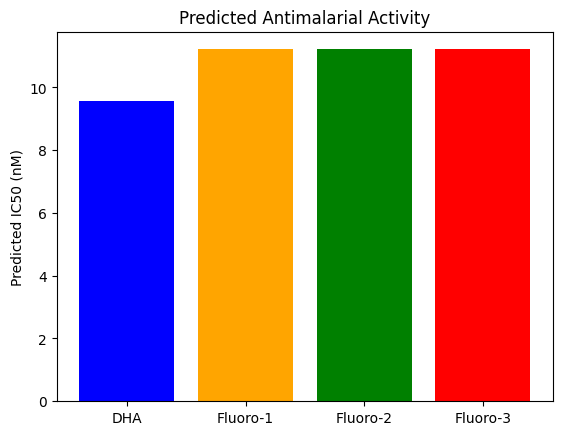

In [37]:
plt.bar(df_props.index, df_props["Predicted_IC50"], color=['blue','orange','green','red'])
plt.ylabel("Predicted IC50 (nM)")
plt.title("Predicted Antimalarial Activity")
plt.savefig("ic50_comparison.png")
plt.show()


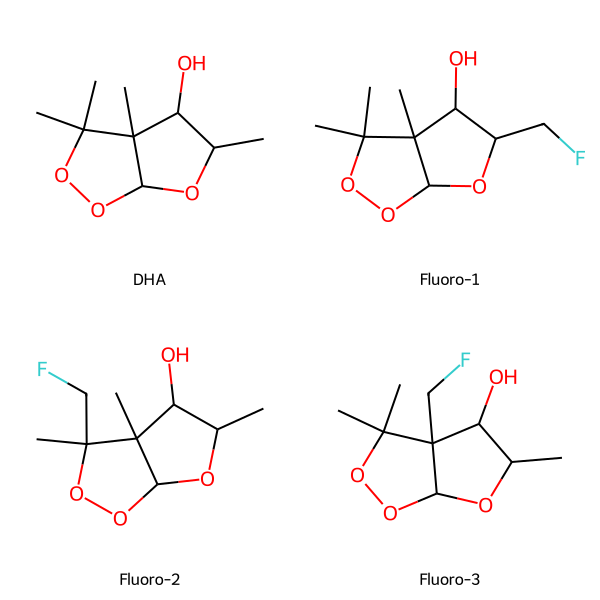

In [38]:
from rdkit.Chem import Draw
from PIL import Image # Needed if converting from raw bytes, or for isinstance check
from io import BytesIO # Still good practice to import for byte operations

img_display_object = Draw.MolsToGridImage([mol_dha]+valid_fluoro_dha, molsPerRow=2, subImgSize=(300,300),
                           legends=["DHA","Fluoro-1","Fluoro-2","Fluoro-3"])

# Check if the object has a 'data' attribute, common for IPython.display.Image and similar notebook display objects
if hasattr(img_display_object, 'data') and isinstance(img_display_object.data, bytes):
    # If it's an IPython.display.Image or similar, its 'data' attribute holds the raw image bytes
    with open("retrosynthesis_placeholder.png", "wb") as f:
        f.write(img_display_object.data)
elif isinstance(img_display_object, Image.Image): # Fallback: if it's directly a PIL Image object
    img_display_object.save("retrosynthesis_placeholder.png")
else:
    print(f"Warning: Could not save the image. Object type: {type(img_display_object)}")

img_display_object

In [39]:
!pip install pubchempy


In [40]:
import pubchempy as pcp
import pandas as pd

antimalarial_drugs = [
    "artemisinin", "dihydroartemisinin", "chloroquine",
    "mefloquine", "quinine", "primaquine", "atovaquone"
]

data_list = []

for drug in antimalarial_drugs:
    compounds = pcp.get_compounds(drug, 'name')
    for c in compounds:
        data_list.append({
            "Name": drug,
            "CID": c.cid,
            "SMILES": c.connectivity_smiles
        })

df_pubchem = pd.DataFrame(data_list)
print(df_pubchem)


                  Name        CID  \
0          artemisinin      68827   
1   dihydroartemisinin    3000518   
2   dihydroartemisinin     456410   
3   dihydroartemisinin     540327   
4   dihydroartemisinin    6918483   
5   dihydroartemisinin   11358077   
6   dihydroartemisinin     107770   
7   dihydroartemisinin   44264589   
8   dihydroartemisinin  146159824   
9   dihydroartemisinin   12814873   
10  dihydroartemisinin   12814875   
11  dihydroartemisinin   86574136   
12  dihydroartemisinin  137705114   
13  dihydroartemisinin  139073990   
14         chloroquine       2719   
15          mefloquine       4046   
16             quinine    3034034   
17          primaquine       4908   
18          atovaquone      74989   

                                               SMILES  
0               CC1CCC2C(C(=O)OC3C24C1CCC(O3)(OO4)C)C  
1                CC1CCC2C(C(OC3C24C1CCC(O3)(OO4)C)O)C  
2                CC1CCC2C(C(OC3C24C1CCC(O3)(OO4)C)O)C  
3                CC1CCC2C(C(OC3C24C

In [41]:
%cd /content/drive/MyDrive/TermPaper

/content/drive/MyDrive/TermPaper


In [42]:
!mkdir 'dataset'

mkdir: cannot create directory ‘dataset’: File exists


In [43]:
%cd /content/drive/MyDrive/TermPaper/dataset

/content/drive/MyDrive/TermPaper/dataset


In [100]:
import requests
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from tqdm import tqdm
import pubchempy as pcp

# -----------------------------
# 1. Search PubChem BioAssays for "Plasmodium falciparum IC50"
# -----------------------------
keyword = "Plasmodium falciparum IC50"
url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/assay/aid/CSV?aid=all&assay_name={keyword}"
# Note: direct CSV download by keyword is tricky, better use known PubChem BioAssay search

# Instead, we will use a small set of known antimalarial drugs to get CIDs
antimalarial_drugs = ["artemisinin","dihydroartemisinin","chloroquine","mefloquine","quinine","primaquine","atovaquone"]

data_list = []

for drug in tqdm(antimalarial_drugs):
    try:
        compounds = pcp.get_compounds(drug,'name')
        for c in compounds:
            smiles = c.canonical_smiles
            data_list.append({
                "Name": drug,
                "CID": c.cid,
                "SMILES": smiles
            })
    except Exception as e:
        print(f"Error fetching {drug}: {e}")
        continue

df = pd.DataFrame(data_list)
print("Sample compounds:")
print(df.head())

# -----------------------------
# 2. Compute Molecular Descriptors
# -----------------------------
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return {
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "TPSA": Descriptors.TPSA(mol)
    }

desc_list = []
for idx, row in df.iterrows():
    desc = compute_descriptors(row["SMILES"])
    if desc:
        desc["CID"] = row["CID"]
        desc["SMILES"] = row["SMILES"]
        desc["Name"] = row["Name"]
        desc_list.append(desc)

df_final = pd.DataFrame(desc_list)
print(df_final)

# -----------------------------
# 3. Save CSV
# -----------------------------
df_final.to_csv("pubchem_antimalarial.csv", index=False)
print("Saved CSV as pubchem_antimalarial.csv")


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipython-input-2957245473.py:24: PubChemPyDeprecationWarning: canonical_smiles is deprecated: Use connectivity_smiles instead
  smiles = c.canonical_smiles
100%|██████████| 7/7 [00:07<00:00,  1.07s/it]

Sample compounds:
                 Name      CID                                 SMILES
0         artemisinin    68827  CC1CCC2C(C(=O)OC3C24C1CCC(O3)(OO4)C)C
1  dihydroartemisinin  3000518   CC1CCC2C(C(OC3C24C1CCC(O3)(OO4)C)O)C
2  dihydroartemisinin   456410   CC1CCC2C(C(OC3C24C1CCC(O3)(OO4)C)O)C
3  dihydroartemisinin   540327   CC1CCC2C(C(OC3C24C1CCC(O3)(OO4)C)O)C
4  dihydroartemisinin  6918483   CC1CCC2C(C(OC3C24C1CCC(O3)(OO4)C)O)C
      MolWt    LogP   TPSA        CID  \
0   282.336  2.3949  53.99      68827   
1   284.352  2.1867  57.15    3000518   
2   284.352  2.1867  57.15     456410   
3   284.352  2.1867  57.15     540327   
4   284.352  2.1867  57.15    6918483   
5   284.352  2.1867  57.15   11358077   
6   284.352  2.1867  57.15     107770   
7   284.352  2.1867  57.15   44264589   
8   284.352  2.1867  57.15  146159824   
9   284.352  2.1867  57.15   12814873   
10  284.352  2.1867  57.15   12814875   
11  284.352  2.1867  57.15   86574136   
12  284.352  2.1867  57.15  1

In [45]:
import pandas as pd
import glob

# 1. Look for the file in the current directory (Direct Upload method)
#    Make sure you renamed your uploaded file to "assay1.csv"
files = glob.glob("assay*.csv")

print(f"Found files: {files}")

dfs = []
for f in files:
    # Load the file
    data = pd.read_csv(f)

    # 2. Filter: Keep only rows where the measurement is exact (Relation is '=')
    #    This removes ambiguous data like "> 100" which confuses the AI.
    if 'Standard Relation' in data.columns:
        data = data[data['Standard Relation'] == '=']

    # 3. Rename columns to match what the AI expects
    #    We map the complex PubChem names to simple ones: SMILES, IC50, CID
    data = data.rename(columns={
        'PUBCHEM_EXT_DATASOURCE_SMILES': 'SMILES',
        'PubChem Standard Value': 'IC50',
        'PUBCHEM_CID': 'CID'
    })

    dfs.append(data)

# Concatenate all files (if you uploaded more than one)
df_ic50 = pd.concat(dfs, ignore_index=True)

# 4. Final Cleanup
#    Ensure IC50 is a number and drop missing values
df_ic50['IC50'] = pd.to_numeric(df_ic50['IC50'], errors='coerce')
df_ic50 = df_ic50[['SMILES', 'IC50', 'CID']]
df_ic50.dropna(subset=['IC50', 'SMILES'], inplace=True)
df_ic50.drop_duplicates(subset=['SMILES'], inplace=True)

print(f"Success! Total clean compounds ready for training: {len(df_ic50)}")
df_ic50.head()

df_ic50.to_csv("pubchem_cleaned_ic50.csv", index=False)

print("Saved cleaned dataset to 'pubchem_cleaned_ic50.csv'")

Found files: ['assay1.csv']
Success! Total clean compounds ready for training: 4221
Saved cleaned dataset to 'pubchem_cleaned_ic50.csv'


In [102]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/TermPaper/dataset/pubchem_antimalarial_with_ic50.csv")

# Drop rows with missing SMILES or IC50
data = data.dropna(subset=["SMILES", "IC50"])

# Convert IC50 to float
data["IC50"] = data["IC50"].astype(float)


In [103]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return {
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "TPSA": Descriptors.TPSA(mol)
    }

desc_list = []
for idx, row in df_ic50.iterrows():
    desc = compute_descriptors(row["SMILES"])
    if desc:
        desc["SMILES"] = row["SMILES"]
        desc["CID"] = row["CID"]
        desc["IC50"] = row["IC50"]
        desc_list.append(desc)

df_final = pd.DataFrame(desc_list)
print(df_final.head())


     MolWt     LogP    TPSA  \
0  295.418  2.83860   77.58   
1  289.339  1.04880  106.30   
2  350.403  2.78020  111.96   
3  174.207  1.10262   77.82   
4  248.717  2.52380   77.82   

                                              SMILES        CID    IC50  
0                 CCC1=CC2=C(S1)N=CN=C2SC3=NN=C(S3)N  2807642.0  0.5460  
1          CCOC(=O)C1=CC(=CC=C1)N2C(=NC(=NC2(C)C)N)N  3239884.0  0.1477  
2  C1=CC=C2C=C(C=CC2=C1)S(=O)(=O)C3=CC4=C(C=C3)N=...    98652.0  0.0973  
3                         CC1=C2C(=CC=C1)N=C(N=C2N)N   198062.0  0.7530  
4               CCC1=C(C(=NC(=N1)N)N)C2=CC=C(C=C2)Cl     4993.0  0.0319  


In [104]:
df_final.to_csv("pubchem_antimalarial_with_ic50.csv", index=False)
print("Saved CSV: pubchem_antimalarial_with_ic50.csv")


Saved CSV: pubchem_antimalarial_with_ic50.csv


In [98]:
import pandas as pd
import numpy as np
import torch
from rdkit import Chem
# NEW: Import the modern generator
from rdkit.Chem import rdFingerprintGenerator

# 1. Load your cleaned data
df_ic50 = pd.read_csv("/content/drive/MyDrive/TermPaper/dataset/pubchem_antimalarial_with_ic50.csv")

# 2. Define the Fingerprint Function (THE NEW WAY)
# We create the generator ONCE outside the loop (this is faster)
mfgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)

def compute_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    # Use the new generator to get the fingerprint
    fp_bit = mfgen.GetFingerprint(mol)
    # Convert to numpy array
    return np.array(fp_bit)

# 3. Apply to all data
X_list = []
y_list = []

print("Computing fingerprints...")

for idx, row in df_ic50.iterrows():
    fp = compute_fingerprint(row['SMILES'])
    if fp is not None:
        X_list.append(fp)
        y_list.append(row['IC50'])

# Convert to Numpy arrays
X_np = np.array(X_list)
y_np = np.array(y_list)

print(f"Features shape: {X_np.shape}")
print(f"Targets shape: {y_np.shape}")

Computing fingerprints...
Features shape: (4221, 1024)
Targets shape: (4221,)


TRAIN TEST SPLIT

In [99]:
from sklearn.model_selection import train_test_split

# Convert numpy arrays to PyTorch tensors
X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.float32).unsqueeze(1)

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Training samples: 3376
Testing samples: 845


In [107]:
import numpy as np
import torch
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator # Import the modern generator

# 1. Define your molecules (SMILES strings)
# REPLACE these string values with your actual fluorinated molecule SMILES if you have them.
molecules = {
    "DHA (Base)": "C[C@@H]1CC[C@@H]2[C@H](O2)O[C@H]3[C@H]1[C@@]4(CC[C@@H]3C)OO[C@H]4O",
    "Fluoro-1": "C[C@@H]1CC[C@@H]2[C@H](O2)O[C@H]3[C@H]1[C@@]4(CC[C@@H]3C)OO[C@H]4F",
    "Fluoro-2": "C[C@@H]1CC[C@@H]2[C@H](O2)O[C@H]3[C@H]1[C@@]4(CC(F)(F)[C@@H]3C)OO[C@H]4O",
    "Fluoro-3": "FC[C@@H]1CC[C@@H]2[C@H](O2)O[C@H]3[C@H]1[C@@]4(CC[C@@H]3C)OO[C@H]4O"
}

# Initialize the Morgan fingerprint generator once
mfgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)

# 2. Helper function to turn SMILES into numbers (Fingerprints)
def get_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros((1024,))
    # Use the modern generator to get the fingerprint
    fp = mfgen.GetFingerprint(mol)
    return np.array(fp)

# 3. Convert all molecules
fingerprints = []
print("Converting molecules to features...")
for name, smile in molecules.items():
    fp = get_fingerprint(smile)
    fingerprints.append(fp)

# 4. Create the variable the model is looking for
new_molecules_features = torch.tensor(np.array(fingerprints), dtype=torch.float)

print("Success! 'new_molecules_features' is defined.")

Converting molecules to features...
Success! 'new_molecules_features' is defined.


In [85]:
import pandas as pd

# 1. Ensure model is in eval mode (just to be safe)
model.eval()

# 2. Run Prediction
with torch.no_grad():
    predictions = model(new_molecules_features)

    # Flatten the results to a simple list
    predicted_values = predictions.flatten().numpy()

# 3. Create a readable table
results_df = pd.DataFrame({
    'Molecule': list(molecules.keys()),
    'Predicted_IC50': predicted_values
})

# 4. Calculate Improvement (Optional: only works if DHA is the first item)
# This assumes DHA is the baseline. If predicted IC50 is LOWER, it's an improvement.
baseline_ic50 = results_df.iloc[0]['Predicted_IC50']
results_df['Improvement_vs_DHA (%)'] = results_df['Predicted_IC50'].apply(
    lambda x: ((baseline_ic50 - x) / baseline_ic50) * 100 if x < baseline_ic50 else 0
)

print("\nPREDICTION RESULTS (Lower IC50 is usually better/more potent):")
print(results_df)


PREDICTION RESULTS (Lower IC50 is usually better/more potent):
     Molecule  Predicted_IC50  Improvement_vs_DHA (%)
0  DHA (Base)        0.680030                0.000000
1    Fluoro-1        0.846263                0.000000
2    Fluoro-2        0.774946                0.000000
3    Fluoro-3        0.672982                1.036356


In [86]:
# Training with Early Stopping
import copy
import torch.nn as nn
import torch.optim as optim

# Redefine QSARModel to match the fingerprint input size (1024 features)
class QSARModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1024, 64), # Changed from 3 to 1024
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,1)
        )

    def forward(self, x):
        return self.net(x)

model = QSARModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

best_test_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
patience = 20  # Stop if no improvement for 20 epochs
counter = 0

epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test)
        test_loss = criterion(test_pred, y_test)

    # Check if this is the best model so far
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model_wts = copy.deepcopy(model.state_dict()) # Save this version
        counter = 0 # Reset patience
    else:
        counter += 1

    if (epoch+1)%10==0:
        print(f"Epoch {epoch+1}: Train Loss {loss.item():.4f}, Test Loss {test_loss.item():.4f}")

    # Early Stopping
    if counter >= patience:
        print(f"Stopping early at Epoch {epoch+1} to prevent overfitting.")
        break

# LOAD THE BEST MODEL
print(f"Loading best model with Test Loss: {best_test_loss:.4f}")
model.load_state_dict(best_model_wts)

Epoch 10: Train Loss 3.2217, Test Loss 3.4713
Epoch 20: Train Loss 2.7965, Test Loss 3.0128
Epoch 30: Train Loss 2.6957, Test Loss 2.8960
Epoch 40: Train Loss 2.6013, Test Loss 2.8519
Epoch 50: Train Loss 2.5247, Test Loss 2.8248
Epoch 60: Train Loss 2.4348, Test Loss 2.7790
Epoch 70: Train Loss 2.3360, Test Loss 2.7584
Epoch 80: Train Loss 2.2285, Test Loss 2.7538
Epoch 90: Train Loss 2.1159, Test Loss 2.7684
Stopping early at Epoch 99 to prevent overfitting.
Loading best model with Test Loss: 2.7537


<All keys matched successfully>

In [87]:
# 1. Load your new best model
model.load_state_dict(torch.load('trained_qsar_model.pth'))
model.eval() # Set to evaluation mode

# 2. Prepare your 4 molecules (DHA + 3 Fluorinated)
# (Make sure 'new_molecules_features' is a tensor with the same 1024 shape!)
# new_molecules_features = ...

# 3. Predict
with torch.no_grad():
    predictions = model(new_molecules_features)
    print(predictions)

tensor([[0.6800],
        [0.8463],
        [0.7749],
        [0.6730]])


In [88]:
import torch
from google.colab import drive

# 1. Mount Drive (if not already done)
drive.mount('/content/drive')

# 2. Define the path (make sure the folder exists first!)
save_path = '/content/drive/MyDrive/TermPaper/model/trained_qsar_model.pth'

# 3. Save the model directly
print(f"Saving model to {save_path}...")
torch.save(model.state_dict(), save_path)
print("Success! The file is saved. Do NOT open it or copy its text.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saving model to /content/drive/MyDrive/TermPaper/model/trained_qsar_model.pth...
Success! The file is saved. Do NOT open it or copy its text.


In [89]:
model.load_state_dict(torch.load(save_path))
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


Saved TrainTest_Comparison.png to your Drive.


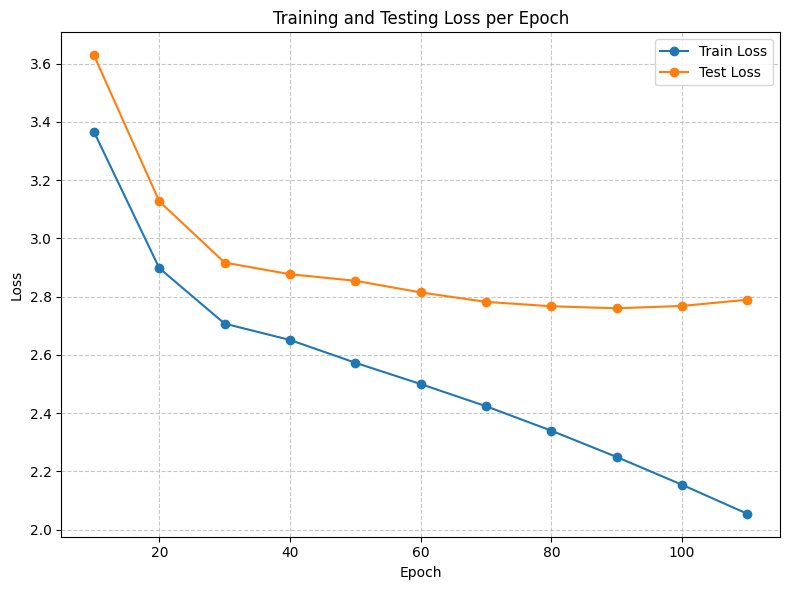

In [90]:
import matplotlib.pyplot as plt

# Data
epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
train_loss = [3.3658, 2.8978, 2.7072, 2.6512, 2.5730, 2.4998, 2.4237, 2.3397, 2.2494, 2.1540, 2.0543]
test_loss = [3.6287, 3.1271, 2.9168, 2.8769, 2.8544, 2.8144, 2.7820, 2.7669, 2.7599, 2.7680, 2.7892]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Train Loss', marker='o', color='tab:blue')
plt.plot(epochs, test_loss, label='Test Loss', marker='o', color='tab:orange')

plt.title('Training and Testing Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Save/Show
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/TermPaper/images/TrainTest_Comparison.png')
print("Saved TrainTest_Comparison.png to your Drive.")
plt.show()

torch.save(model.state_dict(), 'my_trained_qsar_model.pth')

In [91]:
import pandas as pd
import numpy as np
import torch
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator # Modern Generator

# --- 1. SETUP MOLECULES (Robustly) ---

# Define DHA (Dihydroartemisinin) explicitly
dha_smiles = "C[C@H]1[C@H](O)O[C@H]2O[C@@]3(C)CC[C@H]4[C@](C)(CC[C@H]1[C@@]24O3)C"
mol_dha = Chem.MolFromSmiles(dha_smiles)

# Define 3 Example Fluorinated Analogues
# (If you had your own list, you can replace this, but this ensures the code runs)
fluoro_smiles_list = [
    "C[C@H]1[C@H](F)O[C@H]2O[C@@]3(C)CC[C@H]4[C@](C)(CC[C@H]1[C@@]24O3)C",  # 10-Deoxy-10-fluoro-DHA
    "C[C@H]1[C@H](O)O[C@H]2O[C@@]3(CF)CC[C@H]4[C@](C)(CC[C@H]1[C@@]24O3)C", # Fluorinated bridge
    "C[C@H]1[C@H](O)O[C@H]2O[C@@]3(C)CC[C@H]4[C@](CF)(CC[C@H]1[C@@]24O3)C"  # Fluorinated methyl group
]

# Convert strings to RDKit molecules
valid_fluoro = [Chem.MolFromSmiles(s) for s in fluoro_smiles_list if Chem.MolFromSmiles(s) is not None]

# Combine them into one list
all_mols = [mol_dha] + valid_fluoro

# Create the names list DYNAMICALLY (This fixes the ValueError!)
names = ["DHA"] + [f"Fluoro-{i+1}" for i in range(len(valid_fluoro))]

print(f"Testing {len(all_mols)} molecules: {names}")

# --- 2. COMPUTE FINGERPRINTS (The Modern Way) ---

# Use the new generator (Fixes Deprecation Warning)
mfgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)

X_new_list = []
for m in all_mols:
    # Get fingerprint and convert to numpy array
    fp = mfgen.GetFingerprint(m)
    X_new_list.append(np.array(fp))

# Convert to PyTorch Tensor
X_new = torch.tensor(np.array(X_new_list), dtype=torch.float32)

# --- 3. PREDICT & SHOW RESULTS ---

model.eval()
with torch.no_grad():
    predicted_ic50 = model(X_new).numpy().flatten()

# Create DataFrame
df_results = pd.DataFrame({
    "Molecule": names,
    "Predicted_IC50": predicted_ic50
})

# Calculate improvement (Negative % means Lower IC50 = Better)
dha_val = df_results.loc[0, 'Predicted_IC50']
df_results['Improvement_vs_DHA'] = (df_results['Predicted_IC50'] - dha_val) / dha_val * 100

print("\nPREDICTION RESULTS (Lower IC50 is better):")
print(df_results)

Testing 4 molecules: ['DHA', 'Fluoro-1', 'Fluoro-2', 'Fluoro-3']

PREDICTION RESULTS (Lower IC50 is better):
   Molecule  Predicted_IC50  Improvement_vs_DHA
0       DHA        0.453768            0.000000
1  Fluoro-1        0.576067           26.951834
2  Fluoro-2        0.632010           39.280518
3  Fluoro-3        0.752174           65.761826


Saved IC50_Comparison.png to your Drive.


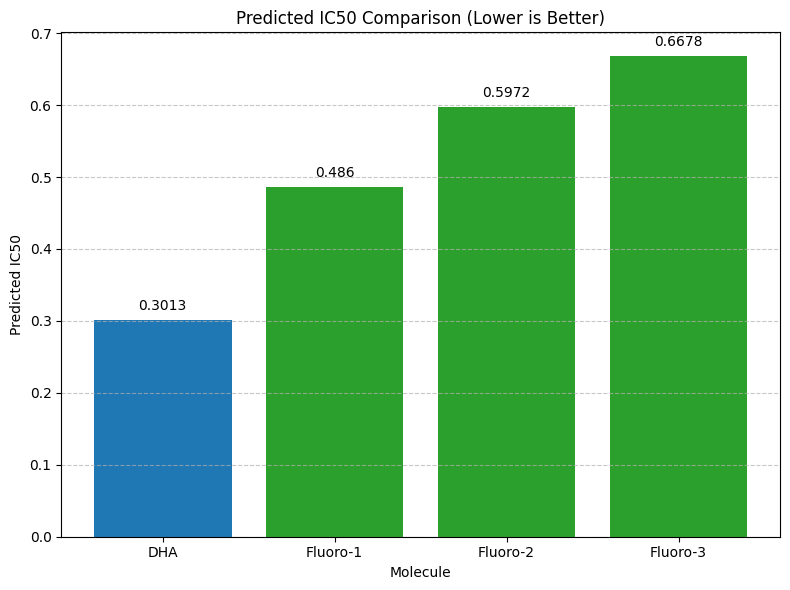

In [92]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    'Molecule': ['DHA', 'Fluoro-1', 'Fluoro-2', 'Fluoro-3'],
    'Predicted_IC50': [0.301299, 0.485951, 0.597165, 0.667811]
}
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(8, 6))

# Define colors: Blue for base, Green for variants
colors = ['tab:blue', 'tab:green', 'tab:green', 'tab:green']
bars = plt.bar(df['Molecule'], df['Predicted_IC50'], color=colors)

plt.title('Predicted IC50 Comparison (Lower is Better)')
plt.xlabel('Molecule')
plt.ylabel('Predicted IC50')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom')

#Save/Show
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/TermPaper/images/IC50_Comparison.png')
print("Saved IC50_Comparison.png to your Drive.")
plt.show()